In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers,models
from matplotlib import pyplot as plt

In [4]:
IMAGE_SIZE=255
BATCH_SIZE=40
EPOCHS=10
CHANNELS=3 #RGB 


In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("training_data/tomato_disease_category", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 6271 files belonging to 4 classes.


In [6]:
print(dataset.class_names)
print(len(dataset.class_names))

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy']
4


In [7]:
print(len(dataset))

157


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    # 1 - 7 because we have 7 classes of tomato diseases
    print(label_batch.numpy()) #numpy() is used to convert tensor to numpy array


[[[199.97647  192.97647  199.97647 ]
  [197.95497  190.95497  197.95497 ]
  [192.94713  185.94713  192.94713 ]
  ...
  [182.80627  175.80627  182.80627 ]
  [180.9589   173.9589   180.9589  ]
  [183.94707  176.94707  183.94707 ]]

 [[190.05882  183.05882  190.05882 ]
  [190.06471  183.06471  190.06471 ]
  [191.04901  184.04901  191.04901 ]
  ...
  [164.15106  157.15106  164.15106 ]
  [154.21764  147.21764  154.21764 ]
  [160.16472  153.16472  160.16472 ]]

 [[199.89218  192.89218  199.89218 ]
  [199.90796  192.90796  199.90796 ]
  [200.91214  193.91214  200.91214 ]
  ...
  [192.76529  185.76529  192.76529 ]
  [180.79626  173.79626  180.79626 ]
  [189.6492   182.6492   189.6492  ]]

 ...

 [[125.980446 110.980446 115.980446]
  [125.99435  110.99435  115.99435 ]
  [125.039566 110.039566 115.039566]
  ...
  [ 98.711006  85.711006  92.711006]
  [ 76.690674  63.690678  70.690674]
  [111.040276  98.040276 105.040276]]

 [[128.98042  113.98043  118.98043 ]
  [127.98237  112.98237  117.98237 ]


2024-07-09 06:54:02.803866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
class_names=dataset.class_names
print(class_names)

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy']


2024-07-09 06:54:02.894443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


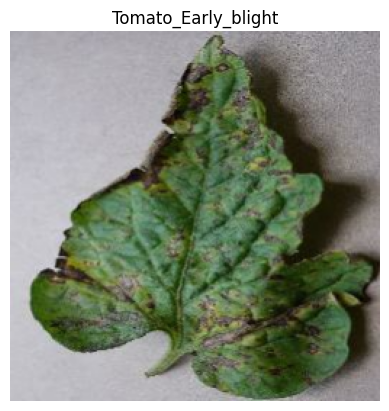

In [10]:
for image_batch,label_batch in dataset.take(1):
    plt.axis("off")
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))


2024-07-09 06:54:03.248076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


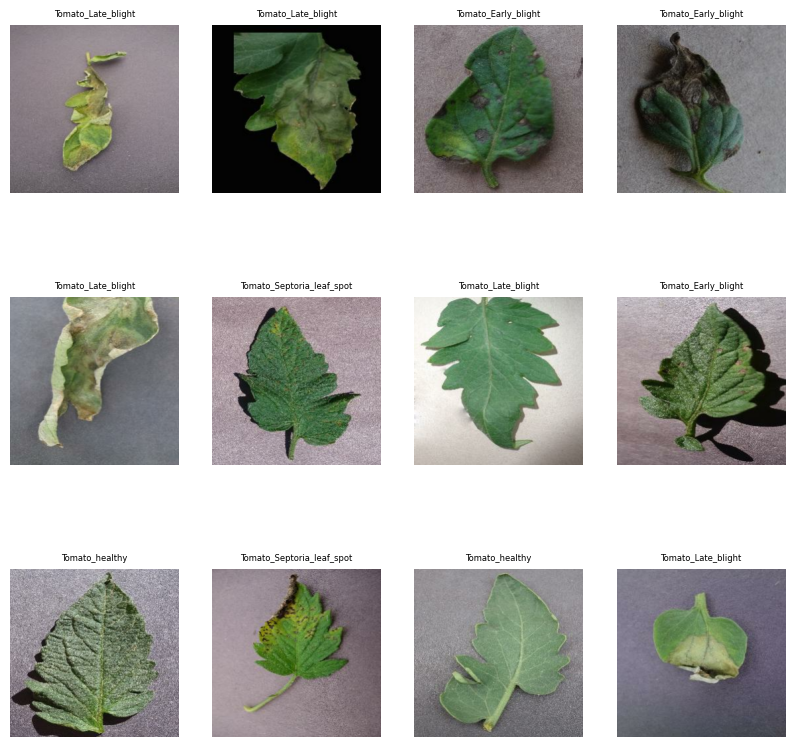

In [11]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=6)
        plt.axis("off")

        

In [12]:
# 80% => training
# 20% => validation, testing

In [13]:
train_size=0.8
train_size=int(train_size*len(dataset))
print(train_size)


125


In [14]:
train_ds=dataset.take(train_size)
len(train_ds)


125

In [15]:
test_ds=dataset.skip(train_size)
len(test_ds)

32

In [16]:
val_size=0.1
len(dataset)*val_size

15.700000000000001

In [17]:
validation_ds=dataset.take(50)
testing_ds=dataset.skip(len(validation_ds))

In [18]:
#cleaner version of the above code
def generate_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_ds=ds.take(round(len(ds)*train_split))
    test_ds=ds.skip(len(train_ds))
    validation_ds=test_ds.take(round(len(test_ds)*val_split))
    testing_ds=test_ds.skip(len(validation_ds))
    print(f"Training: {len(train_ds)}")
    print(f"Validation: {len(validation_ds)}")
    print(f"Testing: {len(testing_ds)}")
    return train_ds, validation_ds, testing_ds

In [19]:
train_ds, validation_ds, testing_ds=generate_partitions_tf(dataset)

Training: 126
Validation: 3
Testing: 28


In [20]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
testing_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
# Rescaling and Rotation
rescale_and_resize=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [22]:
#Data Augmentation 
data_augmentation=keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

2024-07-09 06:54:04.267728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


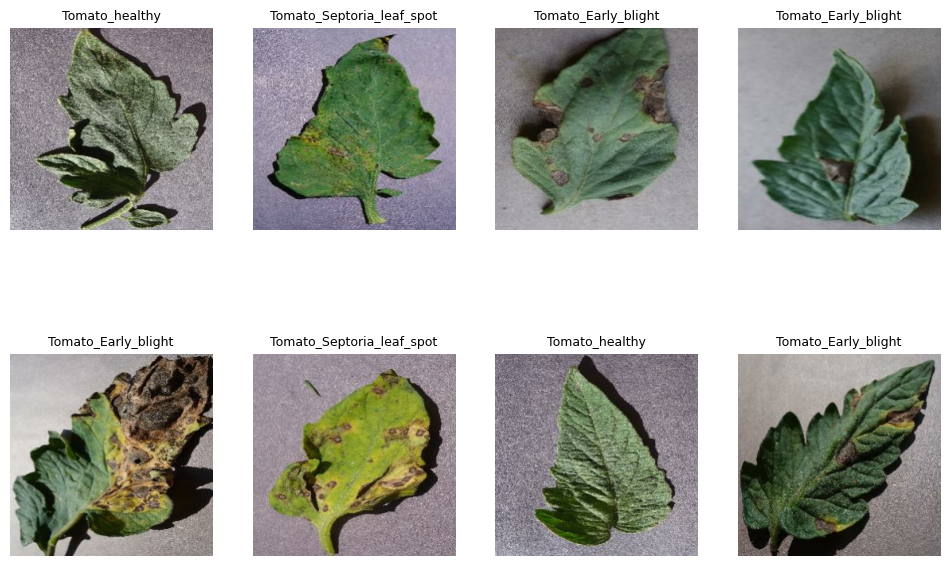

In [23]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=9)
        plt.axis("off")

In [24]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=10
model=models.Sequential([
    rescale_and_resize,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=input_shape)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (40, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (40, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (40, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (40, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (40, 125, 125, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (40, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (40, 61, 61, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (40, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (40, 29, 29, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (40, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (40, 13, 13, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (40, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (40, 5, 5, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (40, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (40, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (40, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (40, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,042 (359.54 KB)

 Trainable params: 92,042 (359.54 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 115s 876ms/step - accuracy: 0.2940 - loss: 1.5223 - val_accuracy: 0.5250 - val_loss: 1.0516
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.5472 - loss: 1.0437 - val_accuracy: 0.5667 - val_loss: 0.8630
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6559 - loss: 0.8194 - val_accuracy: 0.7833 - val_loss: 0.5778
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7389 - loss: 0.6483 - val_accuracy: 0.7750 - val_loss: 0.5620
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.7615 - loss: 0.5916 - val_accuracy: 0.8083 - val_loss: 0.4187
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8227 - loss: 0.4522 - val_accuracy: 0.7917 - val_loss: 0.5414
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8386 - loss: 0.4168 - val_accuracy: 0.8667 - val_loss: 0.3233
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8618 - loss: 0.3454 - val_a

In [37]:
scores= model.evaluate(testing_ds)
print(f"Test Accuracy: {scores[1]*100}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - accuracy: 0.8875 - loss: 0.2828
Test Accuracy: 90.08928537368774


In [38]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 126}

In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [40]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]


Text(0.5, 1.0, 'Training and Validation loss')

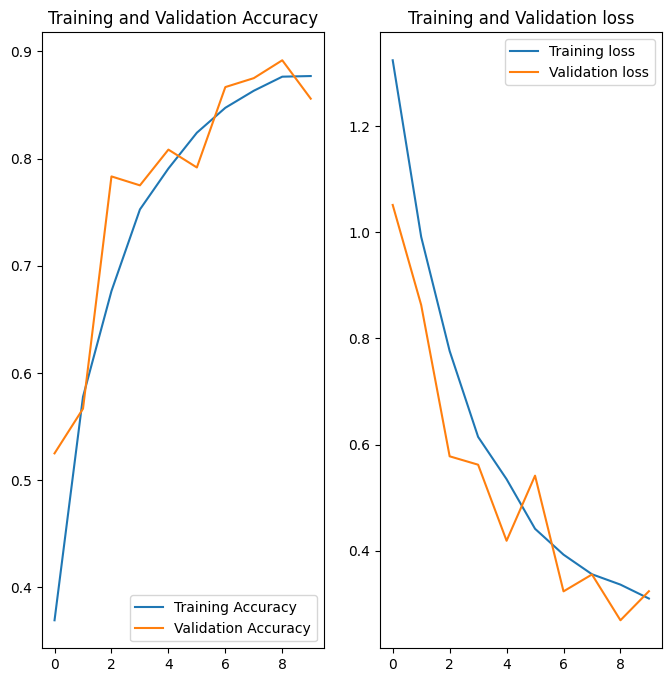

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2
            )
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[1.8739535e-02 7.5822121e-01 2.2303890e-01 3.5674458e-07 1.9746013e-13
 3.9926368e-15 8.0112266e-15 8.2531882e-13 2.0076642e-13 4.5908232e-13]
Predicted: Tomato_Late_blight


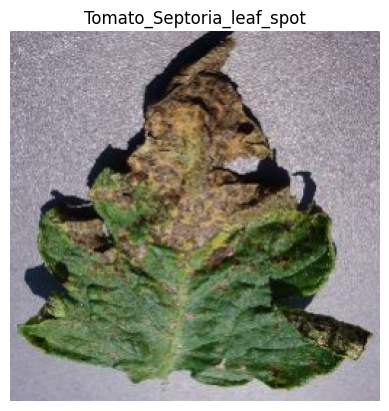

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted: Tomato_Late_blight


2024-07-09 07:31:39.459238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
for images_batch, labels_batch in testing_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    print(first_label)
        #prediction
    predictions=model.predict(images_batch)
    print(predictions[0])
    print(f"Predicted: {class_names[tf.argmax(predictions[0])]}")
    plt.imshow(first_image)
    plt.axis("off")
    plt.title(class_names[first_label])
    plt.show()

    #prediction
    predictions=model.predict(images_batch)
    print(f"Predicted: {class_names[tf.argmax(predictions[0])]}")


In [34]:
import numpy as np

In [50]:
def predict(img, model):
    image_array=tf.keras.preprocessing.image.img_to_array(img)
    image_array=tf.expand_dims(image_array,0)

    predictions=model.predict(image_array)

    predicted_class=class_names[tf.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-07-09 08:43:09.016983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


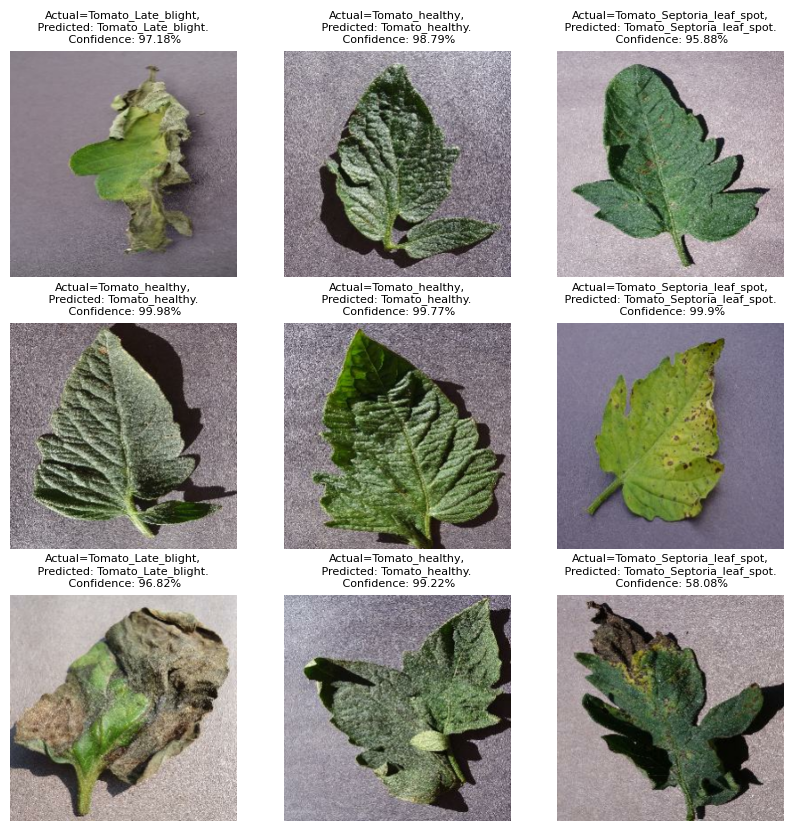

In [54]:
plt.figure(figsize=(10,10))
for images, labels in testing_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
       
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        predicted_class, confidence=predict(images[i].numpy(),model)
        plt.title(f"Actual={class_names[labels[i]]},\n Predicted: {predicted_class}. \n Confidence: {confidence}%",fontdict={"fontsize":8},color="black")

        

        